In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as T
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'
    
modelname = "densenet121"

Available workers: 16


# Creating train,val,test sets

## Removing outliers

In [3]:
df = pd.read_parquet(f"{SAVE_DIR}/df_preparation_{setting}.parquet")
# df = pd.merge(df,df_pre, on=['filename','platename','imgname','date','year','plate_idx','location','xtra'])
# df = df[df.knn_outlier==0]
# df = df[df.nb_contours>0]
# print(df.label.unique())

oe = OrdinalEncoder(cols=['label'],mapping=[{'col':'label', 'mapping':{'bl':0,'wswl':1,'sp':2,'t':3,'sw':4,'k':5,'m':6,'c':7,'v':8,'wmv':9,'wrl':10,'other':11}}])
df['txt_label'] = df['label']
df['label'] = oe.fit_transform(df.label)
df.label.value_counts()

9     5820
8     5642
7     4575
4     3025
0     2406
3     2390
10    1874
6     1552
5     1087
2     1026
1      711
11     517
Name: label, dtype: int64

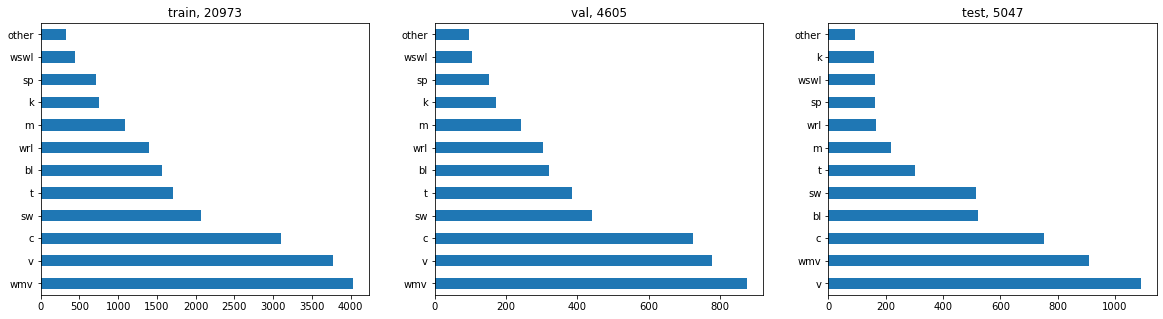

In [4]:
test_plates = train_test_split(df.platename.unique(), random_state=2022, test_size=0.2, shuffle=True)[1].tolist()
testseries = pd.Series(test_plates)
inds = testseries.apply(lambda x: 'wortel' in x)
inds = testseries[inds].sample(11).index.values
wortel_plates = testseries[inds].tolist()
test_plates = testseries[testseries.apply(lambda x: x.split('_')[1] != 'wortel')].tolist() + wortel_plates

df_trainval = df[~df.platename.isin(test_plates)]
df_test = df[df.platename.isin(test_plates)]

topclasses = df['label'].value_counts().head(12).index.tolist()

df = df[df['label'].isin(topclasses)]
df_trainval = df_trainval[df_trainval['label'].isin(topclasses)]
df_test = df_test[df_test['label'].isin(topclasses)]

class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(df['label'].tolist()), 
                                                  y=df['label'].tolist())

class_weights = {np.unique(df['label'])[i]:class_weights[i] for i in range(len(class_weights))}
df['weights'] = df['label'].map(class_weights)

df_train, df_val = train_test_split(df_trainval, test_size=0.18, random_state=42, shuffle=True)


plt.figure(figsize=(20,5))
plt.subplot(1,3,1);df_train.txt_label.value_counts().plot(kind='barh');plt.title(f'train, {df_train.shape[0]}')
plt.subplot(1,3,2);df_val.txt_label.value_counts().plot(kind='barh');plt.title(f'val, {df_val.shape[0]}')
plt.subplot(1,3,3);df_test.txt_label.value_counts().plot(kind='barh');plt.title(f'test, {df_test.shape[0]}');

In [5]:
assert len(set(df_train.filename.tolist()).intersection(df_test.filename.tolist())) == 0
assert len(set(df_train.filename.tolist()).intersection(df_val.filename.tolist())) == 0

In [6]:
df_train.to_parquet(f"{SAVE_DIR}/df_train_{setting}.parquet")
df_val.to_parquet(f"{SAVE_DIR}/df_val_{setting}.parquet")
df_test.to_parquet(f"{SAVE_DIR}/df_test_{setting}.parquet")

In [7]:
df_train.label.value_counts()

9     4035
8     3773
7     3097
4     2069
3     1703
0     1563
10    1404
6     1092
5      756
2      710
1      444
11     327
Name: label, dtype: int64

# Creating Pytorch Datasets and Dataloaders

In [8]:
transforms_list_train = [
#     A.SmallestMaxSize(max_size=150),
    T.ToPILImage(),
    T.Resize(size=(150,150)),
    T.RandomVerticalFlip(p=0.5),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomAutocontrast(p=0.5),
    T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.5),
    T.RandomRotation(degrees=(-15,15)),
    T.RandomPosterize(bits=7, p=0.1),
    # T.RandomEqualize(p=0.5),
    T.ToTensor(),
]

transforms_list_test = [
    T.ToPILImage(),
    T.Resize(size=(150,150)),    
    T.ToTensor(),
]

train_dataset = InsectImgDataset(df=df_train.reset_index(drop=True), transform=T.Compose(transforms_list_train))
valid_dataset = InsectImgDataset(df=df_val.reset_index(drop=True), transform=T.Compose(transforms_list_test))
test_dataset = InsectImgDataset(df=df_test.reset_index(drop=True), transform=T.Compose(transforms_list_test))

batch_size = 32
batch_size_val = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

# plt.imshow(train_dataset[0][0]); plt.title(f"Example train image, class:{train_dataset[0][1]}");

In [9]:
tensor_image = train_dataset[150][0]
# print(tensor_image)
# plt.imshow(  tensor_image.permute(1, 2, 0)  )
# print(tensor_image.permute(1, 2, 0).shape)

#### Defining the model and training parameters

In [10]:
torch.backends.cudnn.benchmark = True

In [11]:
model = model_selector(modelname, pretrained=True)

if modelname.startswith("dense"):
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(
                            nn.Linear(num_ftrs,512),
                            nn.ReLU(),
                            nn.Dropout(0.5),
                            nn.Linear(512, len(topclasses)))
if modelname.startswith("resn"):
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("efficient"):
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("vgg"):
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, len(topclasses))
if modelname.startswith("mobile"):
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, len(topclasses))

In [12]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

num_epochs = 150

class_sample_count = np.unique(df_train.label, return_counts=True)[1]
weight = 1. / class_sample_count  
criterion = nn.CrossEntropyLoss(label_smoothing=.25, weight=torch.Tensor(weight).cuda())

Train on gpu: True


In [13]:
optimizer = optim.AdamW(model.parameters(), lr=.003, weight_decay=0.01)#optim.Adam(model.parameters(), lr=.001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0003, max_lr=0.03, cycle_momentum=False, mode="triangular2")

In [14]:
#optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular2")

# Training

In [15]:
results = {"loss":[], "val_loss":[], "train_accuracy":[], "valid_accuracy":[]}
best_valacc = 0
# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(train_dataloader, desc='Training..\t'):        
        y_batch = torch.as_tensor(y_batch)
        x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
        for param in model.parameters():
            param.grad = None
        pred = model(x_batch)

        y_batch = y_batch.type(torch.LongTensor).cuda()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
    train_accuracy = correct_train / len(train_dataset) * 100.
    torch.cuda.empty_cache()

    
    # Going through the validation set
    correct_valid = 0
    model.eval()
    with torch.no_grad():
        for x_batch,y_batch,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(valid_dataloader, desc='Validating..\t'):
            y_batch = torch.as_tensor(y_batch)
            x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
            pred = model(x_batch)

            y_batch = y_batch.type(torch.LongTensor).cuda()
            correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
            val_loss = criterion(pred, y_batch)
    valid_accuracy = correct_valid / len(valid_dataset) * 100.

    scheduler.step()


    # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.1f}% loss: {loss:.7f},  val_loss: {val_loss:.7f} val_acc: {valid_accuracy:.1f}%")
        
    is_best = valid_accuracy > best_valacc
    if is_best:
        print(f"Validation accuracy improved from {best_valacc:.2f} to {valid_accuracy:.2f}. Saving model..")
    best_valacc = max(valid_accuracy, best_valacc)
    save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'best_valacc': best_valacc,
        'loss': results['loss'].append(loss.detach().cpu()),
        'val_loss': results['val_loss'].append(val_loss.detach().cpu()),
        'train_accuracy': results['train_accuracy'].append(train_accuracy),
        'valid_accuracy': results['valid_accuracy'].append(valid_accuracy),
        'optimizer' : optimizer.state_dict(),
    }, is_best, f"{modelname}_{setting}")


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 24.47it/s]


Epoch 0: train_acc: 53.7% loss: 2.8051958,  val_loss: 2.1765385 val_acc: 55.7%
Validation accuracy improved from 0.00 to 55.72. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 27.97it/s]


Epoch 1: train_acc: 66.2% loss: 2.1097353,  val_loss: 2.0088940 val_acc: 69.7%
Validation accuracy improved from 55.72 to 69.69. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.26it/s]


Epoch 2: train_acc: 70.3% loss: 1.7915487,  val_loss: 2.0149469 val_acc: 72.9%
Validation accuracy improved from 69.69 to 72.92. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.27it/s]


Epoch 3: train_acc: 72.2% loss: 2.1714261,  val_loss: 1.9590340 val_acc: 73.3%
Validation accuracy improved from 72.92 to 73.29. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.19it/s]


Epoch 4: train_acc: 73.9% loss: 2.2429090,  val_loss: 1.9569304 val_acc: 69.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.18it/s]


Epoch 5: train_acc: 74.8% loss: 2.3187015,  val_loss: 1.9025159 val_acc: 77.1%
Validation accuracy improved from 73.29 to 77.11. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.12it/s]


Epoch 6: train_acc: 75.3% loss: 1.9977715,  val_loss: 1.9362729 val_acc: 73.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.41it/s]


Epoch 7: train_acc: 76.2% loss: 2.9790003,  val_loss: 1.8893142 val_acc: 76.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.34it/s]


Epoch 8: train_acc: 77.4% loss: 2.0163960,  val_loss: 1.9809971 val_acc: 68.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.37it/s]


Epoch 9: train_acc: 77.0% loss: 2.8916283,  val_loss: 1.9278746 val_acc: 76.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.38it/s]


Epoch 10: train_acc: 77.6% loss: 2.1620979,  val_loss: 1.9528046 val_acc: 74.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.30it/s]


Epoch 11: train_acc: 78.2% loss: 1.5429450,  val_loss: 1.9618131 val_acc: 78.0%
Validation accuracy improved from 77.11 to 77.98. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.27it/s]


Epoch 12: train_acc: 78.4% loss: 1.6032847,  val_loss: 1.9258540 val_acc: 78.7%
Validation accuracy improved from 77.98 to 78.65. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.34it/s]


Epoch 13: train_acc: 78.3% loss: 1.9223716,  val_loss: 1.8502278 val_acc: 78.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.18it/s]


Epoch 14: train_acc: 79.2% loss: 1.3182532,  val_loss: 1.9911317 val_acc: 75.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.35it/s]


Epoch 15: train_acc: 79.3% loss: 1.5478126,  val_loss: 1.9120755 val_acc: 78.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.24it/s]


Epoch 16: train_acc: 79.7% loss: 1.8366778,  val_loss: 1.9370574 val_acc: 77.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.32it/s]


Epoch 17: train_acc: 80.0% loss: 2.6930962,  val_loss: 1.8383708 val_acc: 78.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.38it/s]


Epoch 18: train_acc: 80.3% loss: 1.6581949,  val_loss: 1.8893645 val_acc: 79.0%
Validation accuracy improved from 78.65 to 78.98. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.34it/s]


Epoch 19: train_acc: 80.2% loss: 2.5076377,  val_loss: 1.9841036 val_acc: 75.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.30it/s]


Epoch 20: train_acc: 80.9% loss: 2.4334643,  val_loss: 1.9613166 val_acc: 76.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.09it/s]


Epoch 21: train_acc: 80.6% loss: 1.3325418,  val_loss: 1.8090348 val_acc: 78.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.37it/s]


Epoch 22: train_acc: 81.6% loss: 2.0473285,  val_loss: 1.8581128 val_acc: 80.3%
Validation accuracy improved from 78.98 to 80.28. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.41it/s]


Epoch 23: train_acc: 81.3% loss: 2.2835333,  val_loss: 1.8499124 val_acc: 79.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.32it/s]


Epoch 24: train_acc: 81.4% loss: 1.7491846,  val_loss: 1.8342886 val_acc: 78.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.34it/s]


Epoch 25: train_acc: 82.0% loss: 1.9453359,  val_loss: 1.8221037 val_acc: 80.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.26it/s]


Epoch 26: train_acc: 82.5% loss: 2.7293892,  val_loss: 1.7586854 val_acc: 79.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.39it/s]


Epoch 27: train_acc: 82.0% loss: 1.9574739,  val_loss: 1.9491677 val_acc: 77.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.42it/s]


Epoch 28: train_acc: 82.1% loss: 2.1387761,  val_loss: 1.8940861 val_acc: 75.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.45it/s]


Epoch 29: train_acc: 82.1% loss: 1.6205885,  val_loss: 1.7899835 val_acc: 79.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.16it/s]


Epoch 30: train_acc: 82.0% loss: 2.3484063,  val_loss: 1.9011071 val_acc: 77.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.33it/s]


Epoch 31: train_acc: 82.7% loss: 1.6950159,  val_loss: 1.8320761 val_acc: 78.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.35it/s]


Epoch 32: train_acc: 82.8% loss: 1.6730397,  val_loss: 1.8565145 val_acc: 79.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.40it/s]


Epoch 33: train_acc: 82.8% loss: 1.4295967,  val_loss: 1.7679268 val_acc: 78.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.36it/s]


Epoch 34: train_acc: 83.1% loss: 1.6584678,  val_loss: 1.9498489 val_acc: 78.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.44it/s]


Epoch 35: train_acc: 83.0% loss: 2.5831857,  val_loss: 1.8030738 val_acc: 80.8%
Validation accuracy improved from 80.28 to 80.83. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.51it/s]


Epoch 36: train_acc: 83.8% loss: 1.6969614,  val_loss: 1.9458163 val_acc: 75.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.39it/s]


Epoch 37: train_acc: 83.6% loss: 2.3331776,  val_loss: 1.9160358 val_acc: 78.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.47it/s]


Epoch 38: train_acc: 83.6% loss: 1.7741412,  val_loss: 1.8945787 val_acc: 79.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.47it/s]


Epoch 39: train_acc: 83.8% loss: 2.3967133,  val_loss: 1.8772905 val_acc: 79.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.50it/s]


Epoch 40: train_acc: 84.1% loss: 1.4943385,  val_loss: 1.8186167 val_acc: 79.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.38it/s]


Epoch 41: train_acc: 84.1% loss: 1.8064346,  val_loss: 1.8865638 val_acc: 75.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.53it/s]


Epoch 42: train_acc: 84.0% loss: 3.4107246,  val_loss: 1.7725847 val_acc: 77.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.47it/s]


Epoch 43: train_acc: 84.2% loss: 1.6346016,  val_loss: 1.8814919 val_acc: 78.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.57it/s]


Epoch 44: train_acc: 84.0% loss: 1.6471610,  val_loss: 2.0861263 val_acc: 78.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.49it/s]


Epoch 45: train_acc: 84.6% loss: 1.2923607,  val_loss: 1.8763919 val_acc: 81.2%
Validation accuracy improved from 80.83 to 81.15. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.55it/s]


Epoch 46: train_acc: 84.5% loss: 1.7953385,  val_loss: 1.8809860 val_acc: 77.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.58it/s]


Epoch 47: train_acc: 84.3% loss: 1.8521969,  val_loss: 1.9152094 val_acc: 79.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.63it/s]


Epoch 48: train_acc: 84.6% loss: 1.7209297,  val_loss: 1.8798494 val_acc: 80.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.46it/s]


Epoch 49: train_acc: 84.7% loss: 1.4024193,  val_loss: 1.8350855 val_acc: 79.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.56it/s]


Epoch 50: train_acc: 85.1% loss: 2.3392615,  val_loss: 1.9647899 val_acc: 78.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.54it/s]


Epoch 51: train_acc: 85.0% loss: 2.3058138,  val_loss: 1.7619486 val_acc: 80.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.44it/s]


Epoch 52: train_acc: 85.1% loss: 1.8801211,  val_loss: 1.7571838 val_acc: 80.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.58it/s]


Epoch 53: train_acc: 85.0% loss: 1.4714880,  val_loss: 1.7726047 val_acc: 80.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.45it/s]


Epoch 54: train_acc: 85.6% loss: 1.7716277,  val_loss: 1.8183744 val_acc: 79.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.50it/s]


Epoch 55: train_acc: 84.9% loss: 2.0861771,  val_loss: 1.9556010 val_acc: 79.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.15it/s]


Epoch 56: train_acc: 85.0% loss: 1.5020823,  val_loss: 1.8129779 val_acc: 78.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.52it/s]


Epoch 57: train_acc: 85.7% loss: 1.7431159,  val_loss: 1.9243083 val_acc: 75.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.53it/s]


Epoch 58: train_acc: 85.3% loss: 1.7678639,  val_loss: 1.8688287 val_acc: 79.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.44it/s]


Epoch 59: train_acc: 85.7% loss: 1.8357866,  val_loss: 1.9305546 val_acc: 77.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.31it/s]


Epoch 60: train_acc: 85.7% loss: 1.6224140,  val_loss: 1.8689946 val_acc: 79.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.48it/s]


Epoch 61: train_acc: 85.6% loss: 2.2927470,  val_loss: 1.9396031 val_acc: 73.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.46it/s]


Epoch 62: train_acc: 86.0% loss: 2.1089253,  val_loss: 1.8804185 val_acc: 78.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.51it/s]


Epoch 63: train_acc: 85.7% loss: 1.9417341,  val_loss: 1.8407865 val_acc: 76.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.54it/s]


Epoch 64: train_acc: 86.4% loss: 1.4457788,  val_loss: 1.7464418 val_acc: 79.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.54it/s]


Epoch 65: train_acc: 85.9% loss: 2.1452286,  val_loss: 1.8838763 val_acc: 79.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.45it/s]


Epoch 66: train_acc: 85.8% loss: 1.9696581,  val_loss: 1.9901837 val_acc: 72.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.56it/s]


Epoch 67: train_acc: 85.9% loss: 2.4019649,  val_loss: 1.9302647 val_acc: 76.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.55it/s]


Epoch 68: train_acc: 86.2% loss: 2.2827187,  val_loss: 1.8112636 val_acc: 80.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.52it/s]


Epoch 69: train_acc: 86.8% loss: 2.1457396,  val_loss: 1.7934854 val_acc: 77.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.42it/s]


Epoch 70: train_acc: 85.9% loss: 1.8359044,  val_loss: 1.8561693 val_acc: 79.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.40it/s]


Epoch 71: train_acc: 85.8% loss: 1.9285839,  val_loss: 1.8084803 val_acc: 81.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.50it/s]


Epoch 72: train_acc: 86.5% loss: 1.9236531,  val_loss: 1.8575457 val_acc: 76.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.49it/s]


Epoch 73: train_acc: 86.6% loss: 2.2843275,  val_loss: 1.8641288 val_acc: 77.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.45it/s]


Epoch 74: train_acc: 86.8% loss: 1.5866725,  val_loss: 1.8108025 val_acc: 77.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.48it/s]


Epoch 75: train_acc: 85.9% loss: 2.2079558,  val_loss: 1.7624059 val_acc: 79.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.51it/s]


Epoch 76: train_acc: 86.6% loss: 1.3025243,  val_loss: 1.8708301 val_acc: 78.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.60it/s]


Epoch 77: train_acc: 86.5% loss: 2.1511703,  val_loss: 1.9283448 val_acc: 78.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.54it/s]


Epoch 78: train_acc: 86.3% loss: 1.7123247,  val_loss: 1.8554044 val_acc: 78.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.58it/s]


Epoch 79: train_acc: 86.8% loss: 1.5220317,  val_loss: 1.8771437 val_acc: 78.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.54it/s]


Epoch 80: train_acc: 87.2% loss: 1.7826202,  val_loss: 1.8481121 val_acc: 77.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.44it/s]


Epoch 81: train_acc: 87.1% loss: 1.9139322,  val_loss: 1.8381107 val_acc: 79.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.42it/s]


Epoch 82: train_acc: 87.2% loss: 1.6939220,  val_loss: 1.7983603 val_acc: 79.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 27.95it/s]


Epoch 83: train_acc: 86.9% loss: 1.4990944,  val_loss: 1.8612260 val_acc: 77.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.62it/s]


Epoch 84: train_acc: 87.2% loss: 1.7131356,  val_loss: 1.9004987 val_acc: 78.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.68it/s]


Epoch 85: train_acc: 86.4% loss: 1.5882946,  val_loss: 1.9085515 val_acc: 76.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.59it/s]


Epoch 86: train_acc: 87.1% loss: 2.7086887,  val_loss: 1.8195591 val_acc: 75.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.54it/s]


Epoch 87: train_acc: 87.2% loss: 1.4887271,  val_loss: 1.9217278 val_acc: 80.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.59it/s]


Epoch 88: train_acc: 87.5% loss: 1.8142210,  val_loss: 1.9107180 val_acc: 80.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.56it/s]


Epoch 89: train_acc: 86.6% loss: 1.9800217,  val_loss: 1.9867451 val_acc: 77.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.50it/s]


Epoch 90: train_acc: 87.7% loss: 1.7545878,  val_loss: 1.9324219 val_acc: 80.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.52it/s]


Epoch 91: train_acc: 87.6% loss: 1.3520865,  val_loss: 1.8036937 val_acc: 81.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.63it/s]


Epoch 92: train_acc: 86.9% loss: 1.4566436,  val_loss: 1.8625832 val_acc: 77.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.59it/s]


Epoch 93: train_acc: 87.5% loss: 2.0971498,  val_loss: 1.8326929 val_acc: 78.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.65it/s]


Epoch 94: train_acc: 87.3% loss: 2.5350649,  val_loss: 1.8147063 val_acc: 78.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.56it/s]


Epoch 95: train_acc: 87.5% loss: 1.8430593,  val_loss: 1.9030193 val_acc: 77.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.33it/s]


Epoch 96: train_acc: 87.1% loss: 2.3164396,  val_loss: 1.8230908 val_acc: 80.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.35it/s]


Epoch 97: train_acc: 87.1% loss: 2.3065042,  val_loss: 1.8786762 val_acc: 80.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.61it/s]


Epoch 98: train_acc: 88.2% loss: 2.0651662,  val_loss: 1.8964704 val_acc: 77.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.60it/s]


Epoch 99: train_acc: 87.2% loss: 2.1422496,  val_loss: 1.8088111 val_acc: 80.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.37it/s]


Epoch 100: train_acc: 87.5% loss: 1.9346423,  val_loss: 1.8858163 val_acc: 79.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.59it/s]


Epoch 101: train_acc: 87.3% loss: 2.1730928,  val_loss: 1.9293972 val_acc: 80.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.54it/s]


Epoch 102: train_acc: 87.2% loss: 1.8763038,  val_loss: 1.8908067 val_acc: 80.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.51it/s]


Epoch 103: train_acc: 88.3% loss: 1.6621897,  val_loss: 1.8512639 val_acc: 79.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.52it/s]


Epoch 104: train_acc: 87.8% loss: 2.7857985,  val_loss: 1.7834249 val_acc: 78.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.49it/s]


Epoch 105: train_acc: 88.0% loss: 2.6222100,  val_loss: 1.8114378 val_acc: 81.5%
Validation accuracy improved from 81.15 to 81.52. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.48it/s]


Epoch 106: train_acc: 87.7% loss: 1.9227455,  val_loss: 1.8419280 val_acc: 78.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.62it/s]


Epoch 107: train_acc: 87.8% loss: 2.3666873,  val_loss: 1.8454074 val_acc: 77.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.61it/s]


Epoch 108: train_acc: 87.2% loss: 1.5560393,  val_loss: 1.8312296 val_acc: 78.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.58it/s]


Epoch 109: train_acc: 87.9% loss: 2.7953036,  val_loss: 1.7637258 val_acc: 80.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.55it/s]


Epoch 110: train_acc: 88.1% loss: 1.3504095,  val_loss: 1.9040360 val_acc: 80.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.50it/s]


Epoch 111: train_acc: 87.8% loss: 2.3517511,  val_loss: 1.8513892 val_acc: 78.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.53it/s]


Epoch 112: train_acc: 87.9% loss: 1.5428578,  val_loss: 1.7920101 val_acc: 79.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.62it/s]


Epoch 113: train_acc: 87.8% loss: 1.7978177,  val_loss: 1.8193610 val_acc: 80.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.57it/s]


Epoch 114: train_acc: 87.8% loss: 2.3432879,  val_loss: 1.8698523 val_acc: 77.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.50it/s]


Epoch 115: train_acc: 87.4% loss: 2.5131783,  val_loss: 1.9007318 val_acc: 80.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.19it/s]


Epoch 116: train_acc: 88.1% loss: 1.5422070,  val_loss: 2.0154500 val_acc: 76.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.52it/s]


Epoch 117: train_acc: 87.2% loss: 1.4231318,  val_loss: 1.8063316 val_acc: 80.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.52it/s]


Epoch 118: train_acc: 88.7% loss: 1.6312699,  val_loss: 1.7217524 val_acc: 80.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.51it/s]


Epoch 119: train_acc: 87.7% loss: 1.4151386,  val_loss: 1.8905306 val_acc: 80.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.59it/s]


Epoch 120: train_acc: 87.7% loss: 1.8395517,  val_loss: 1.8447113 val_acc: 78.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.61it/s]


Epoch 121: train_acc: 88.2% loss: 1.4004617,  val_loss: 1.9289786 val_acc: 80.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.09it/s]


Epoch 122: train_acc: 87.3% loss: 2.3299353,  val_loss: 2.0293989 val_acc: 78.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.44it/s]


Epoch 123: train_acc: 88.2% loss: 2.3383405,  val_loss: 1.8429465 val_acc: 79.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.53it/s]


Epoch 124: train_acc: 88.0% loss: 2.1032059,  val_loss: 1.7510648 val_acc: 81.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.54it/s]


Epoch 125: train_acc: 87.9% loss: 1.4130912,  val_loss: 1.9574978 val_acc: 80.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.62it/s]


Epoch 126: train_acc: 88.3% loss: 1.9910184,  val_loss: 1.9640534 val_acc: 75.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.15it/s]


Epoch 127: train_acc: 88.0% loss: 2.3427134,  val_loss: 1.8277225 val_acc: 78.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.64it/s]


Epoch 128: train_acc: 87.8% loss: 2.5732155,  val_loss: 1.8246247 val_acc: 79.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.56it/s]


Epoch 129: train_acc: 87.5% loss: 2.3633604,  val_loss: 1.8274890 val_acc: 80.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.71it/s]


Epoch 130: train_acc: 88.6% loss: 1.6562212,  val_loss: 1.9273005 val_acc: 75.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.51it/s]


Epoch 131: train_acc: 88.1% loss: 1.2022685,  val_loss: 2.1422734 val_acc: 67.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.28it/s]


Epoch 132: train_acc: 88.0% loss: 2.0433869,  val_loss: 1.7981210 val_acc: 80.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.64it/s]


Epoch 133: train_acc: 87.8% loss: 2.3047409,  val_loss: 1.8230705 val_acc: 80.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.67it/s]


Epoch 134: train_acc: 87.7% loss: 1.5387919,  val_loss: 1.8403460 val_acc: 78.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.56it/s]


Epoch 135: train_acc: 88.2% loss: 2.2580512,  val_loss: 1.8278496 val_acc: 79.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.68it/s]


Epoch 136: train_acc: 87.8% loss: 1.7963756,  val_loss: 1.8732429 val_acc: 78.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.64it/s]


Epoch 137: train_acc: 87.3% loss: 1.3690789,  val_loss: 1.9293635 val_acc: 78.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.58it/s]


Epoch 138: train_acc: 88.4% loss: 1.6197917,  val_loss: 1.8712741 val_acc: 79.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.62it/s]


Epoch 139: train_acc: 88.2% loss: 1.8060682,  val_loss: 1.8422744 val_acc: 81.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.56it/s]


Epoch 140: train_acc: 87.2% loss: 2.2286799,  val_loss: 1.8966224 val_acc: 79.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.66it/s]


Epoch 141: train_acc: 87.3% loss: 2.4088192,  val_loss: 1.8730310 val_acc: 81.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.63it/s]


Epoch 142: train_acc: 88.2% loss: 2.2026677,  val_loss: 1.8069468 val_acc: 81.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.51it/s]


Epoch 143: train_acc: 87.3% loss: 2.0617919,  val_loss: 1.9819926 val_acc: 80.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.55it/s]


Epoch 144: train_acc: 88.5% loss: 2.1697841,  val_loss: 1.9049586 val_acc: 78.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.63it/s]


Epoch 145: train_acc: 88.4% loss: 2.0694606,  val_loss: 1.8145611 val_acc: 78.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.62it/s]


Epoch 146: train_acc: 88.0% loss: 2.1123929,  val_loss: 1.9643761 val_acc: 76.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.61it/s]


Epoch 147: train_acc: 88.2% loss: 1.3363565,  val_loss: 1.9308364 val_acc: 75.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.44it/s]


Epoch 148: train_acc: 87.7% loss: 2.2100186,  val_loss: 2.0559206 val_acc: 69.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:05<00:00, 28.30it/s]


Epoch 149: train_acc: 88.0% loss: 2.7319565,  val_loss: 1.9842227 val_acc: 79.4%


In [16]:
x_batch[0].shape

torch.Size([3, 150, 150])

In [17]:
train_dataset